In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error

# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv("ScreenTime vs MentalWellness.csv")

In [5]:
df.head()

,user_id,age,gender,occupation,work_mode,screen_time_hours,work_screen_hours,leisure_screen_hours,sleep_hours,sleep_quality_1_5,stress_level_0_10,productivity_0_100,mental_wellness_index_0_100,exercise_hours,social_hours,age_group,wellness_group
0,U0001,33,Female,Employed,Remote,10.79,5.44,5.35,6.63,1,9.3,44.7,9.3,0.302381,0.100000,Old,Not Favorable
1,U0002,28,Female,Employed,In-person,7.40,0.37,7.03,8.05,3,5.7,78.0,56.2,0.176190,0.300000,Young,Favorable
2,U0003,35,Female,Employed,Hybrid,9.78,1.09,8.69,6.48,1,9.1,51.8,3.6,0.159524,1.142857,Old,Not Favorable
3,U0004,42,Male,Employed,Hybrid,11.13,0.56,10.57,6.89,1,10.0,37.0,0.0,0.000000,0.814286,Older,Not Favorable
4,U0005,28,Male,Student,Remote,13.22,4.09,9.13,5.79,1,10.0,38.5,0.0,0.340476,1.442857,Young,Not Favorable


In [ ]:
df.info()

In [3]:
df = df.drop("Unnamed: 15", axis=1)
df["exercise_hours"] = df["exercise_minutes_per_week"] / (60 * 7)
df = df.drop("exercise_minutes_per_week", axis=1)
df.loc[df["occupation"].isin(["Retired", "Unemployed"]), "occupation"] = pd.NA
df["social_hours"] = df["social_hours_per_week"] / 7
df = df.drop("social_hours_per_week", axis=1)
df["age_group"] = pd.qcut(df["age"], 4, labels=["Younger", "Young", "Old", "Older"])

In [4]:
median = df["mental_wellness_index_0_100"].median()

df["wellness_group"] = pd.cut(
    df["mental_wellness_index_0_100"],
    bins=[-float("inf"), median, float("inf")],
    labels=["Not Favorable", "Favorable"],
    include_lowest=True
)
df["wellness_group"].value_counts()

wellness_group
Not Favorable    201
Favorable        199
Name: count, dtype: int64

In [6]:
X = df.select_dtypes(include=['number']).drop('mental_wellness_index_0_100', axis=1)
X.head()

,age,screen_time_hours,work_screen_hours,leisure_screen_hours,sleep_hours,sleep_quality_1_5,stress_level_0_10,productivity_0_100,exercise_hours,social_hours
0,33,10.79,5.44,5.35,6.63,1,9.3,44.7,0.302381,0.100000
1,28,7.40,0.37,7.03,8.05,3,5.7,78.0,0.176190,0.300000
2,35,9.78,1.09,8.69,6.48,1,9.1,51.8,0.159524,1.142857
3,42,11.13,0.56,10.57,6.89,1,10.0,37.0,0.000000,0.814286
4,28,13.22,4.09,9.13,5.79,1,10.0,38.5,0.340476,1.442857


In [7]:
Y = df['mental_wellness_index_0_100']
Y.head()

0     9.3
1    56.2
2     3.6
3     0.0
4     0.0
Name: mental_wellness_index_0_100, dtype: float64

In [10]:
model = SVR()

In [12]:
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", model)
])
pipe.get_params()

{'memory': None,
 'steps': [('scale', StandardScaler()), ('model', SVR())],
 'transform_input': None,
 'verbose': False,
 'scale': StandardScaler(),
 'model': SVR(),
 'scale__copy': True,
 'scale__with_mean': True,
 'scale__with_std': True,
 'model__C': 1.0,
 'model__cache_size': 200,
 'model__coef0': 0.0,
 'model__degree': 3,
 'model__epsilon': 0.1,
 'model__gamma': 'scale',
 'model__kernel': 'rbf',
 'model__max_iter': -1,
 'model__shrinking': True,
 'model__tol': 0.001,
 'model__verbose': False}

In [14]:
mod = GridSearchCV(estimator=pipe,
                   param_grid={"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"]},
                   cv=3)

In [ ]:
mod = GridSearchCV(estimator=pipe,
                    param_grid={"model__n_neighbors": list(range(1, 10))},
                    cv=3)

In [16]:
mod.fit(X, Y)
pd.DataFrame(mod.cv_results_).sort_values("rank_test_score").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.016715,0.003512,0.002259,0.000208,10.0,linear,"{'model__C': 10, 'model__kernel': 'linear'}",0.947556,0.915264,0.924157,0.928992,0.013619,1
2,0.007675,0.001355,0.002086,0.000077,1.0,linear,"{'model__C': 1, 'model__kernel': 'linear'}",0.944114,0.916818,0.925045,0.928659,0.011433,2
0,0.009283,0.001125,0.005329,0.001917,0.1,linear,"{'model__C': 0.1, 'model__kernel': 'linear'}",0.911342,0.900674,0.921983,0.911333,0.008699,3
5,0.007513,0.001234,0.004153,0.000366,10.0,rbf,"{'model__C': 10, 'model__kernel': 'rbf'}",0.843049,0.803053,0.846637,0.830913,0.019754,4
3,0.004853,0.000094,0.003507,0.000223,1.0,rbf,"{'model__C': 1, 'model__kernel': 'rbf'}",0.523793,0.553303,0.661189,0.579428,0.059055,5


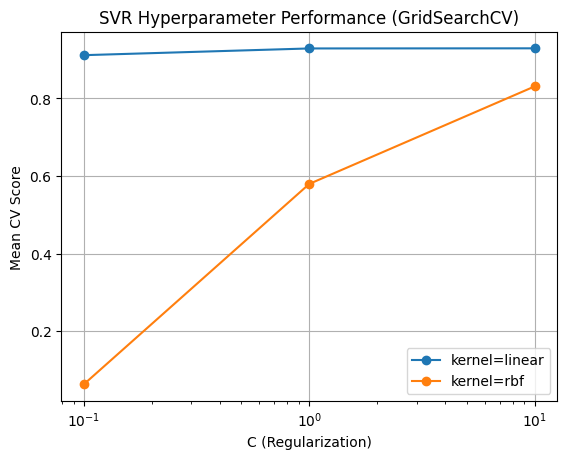

In [17]:
results = pd.DataFrame(mod.cv_results_)

for kernel in results['param_model__kernel'].unique():
    subset = results[results['param_model__kernel'] == kernel]
    plt.plot(subset['param_model__C'],
             subset['mean_test_score'],
             marker='o',
             label=f'kernel={kernel}')

plt.xscale('log')
plt.xlabel('C (Regularization)')
plt.ylabel('Mean CV Score')
plt.title('SVR Hyperparameter Performance (GridSearchCV)')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

best_model = mod.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

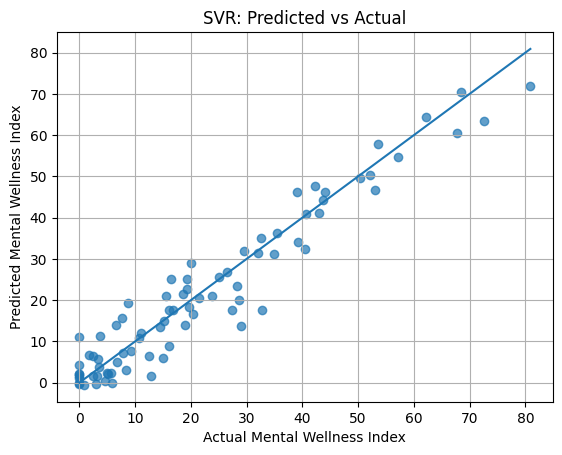

In [21]:
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel('Actual Mental Wellness Index')
plt.ylabel('Predicted Mental Wellness Index')
plt.title('SVR: Predicted vs Actual')
plt.grid(True)
plt.show()


In [24]:
mean_squared_error(y_test, y_pred)

29.546262296393127

In [25]:
root_mean_squared_error(y_test, y_pred)

5.435647366817785

In [26]:
# Diagnostic: Check training vs test error
train_pred = best_model.predict(X_train)
train_rmse = root_mean_squared_error(y_train, train_pred)
test_rmse = root_mean_squared_error(y_test, y_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Target range: {Y.min():.2f} to {Y.max():.2f}")
print(f"Target mean: {Y.mean():.2f}, std: {Y.std():.2f}")


Train RMSE: 5.1256
Test RMSE: 5.4356
Target range: 0.00 to 97.00
Target mean: 20.33, std: 20.38


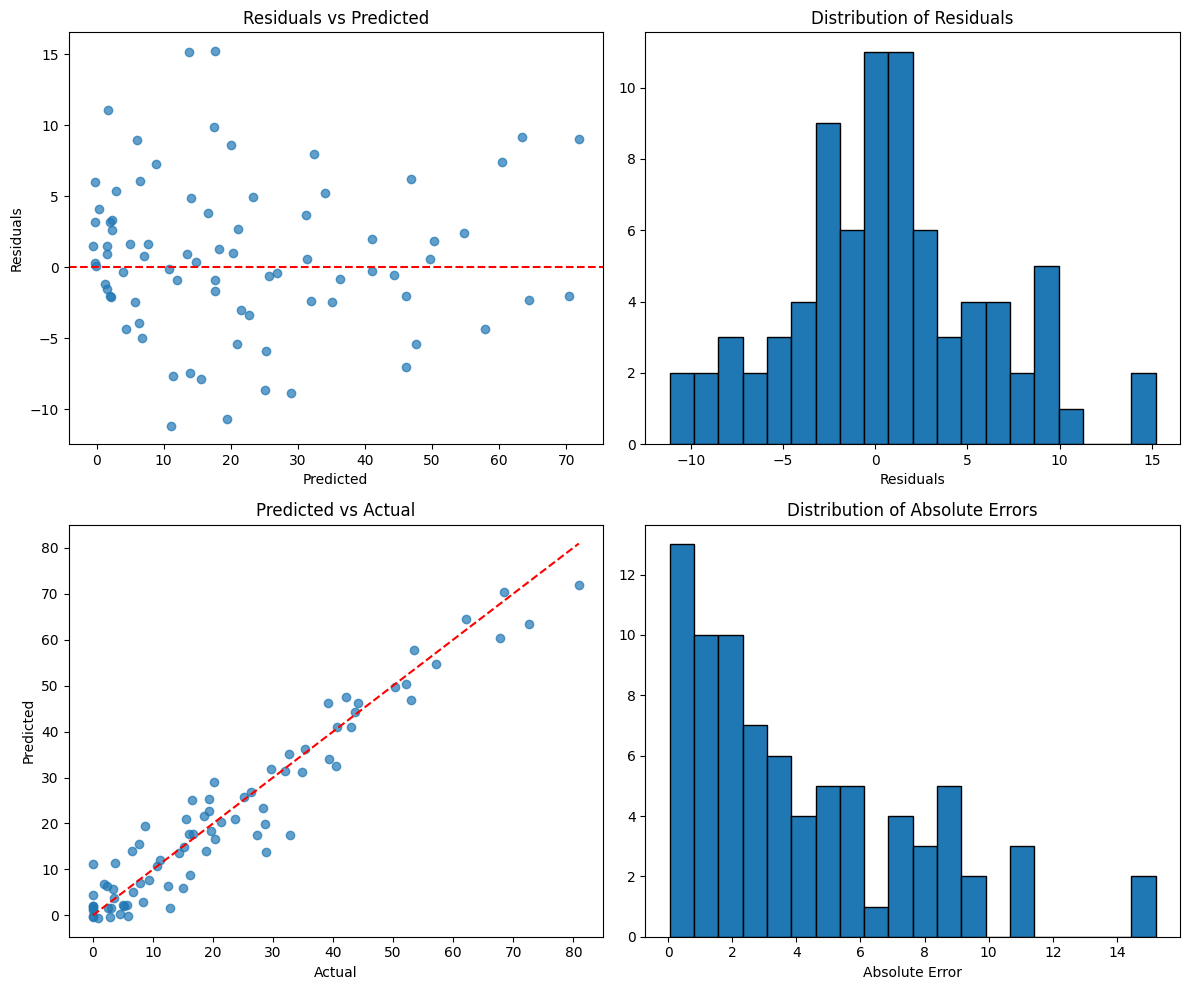

Mean residual: 0.7087
Std of residuals: 5.4232


In [29]:
# Diagnostic: Residuals analysis
residuals = y_test - y_pred

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residuals vs predicted
axes[0, 0].scatter(y_pred, residuals, alpha=0.7)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted')

# Residuals distribution
axes[0, 1].hist(residuals, bins=20, edgecolor='black')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_title('Distribution of Residuals')

# Prediction range
axes[1, 0].scatter(y_test, y_pred, alpha=0.7)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title('Predicted vs Actual')

# Error distribution
axes[1, 1].hist(np.abs(residuals), bins=20, edgecolor='black')
axes[1, 1].set_xlabel('Absolute Error')
axes[1, 1].set_title('Distribution of Absolute Errors')

plt.tight_layout()
plt.show()

print(f"Mean residual: {residuals.mean():.4f}")
print(f"Std of residuals: {residuals.std():.4f}")


In [ ]:
pred = mod.fit(X, Y).predict(X)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=pred)

In [30]:
from sklearn.ensemble import RandomForestRegressor

# Create Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Create pipeline
rf_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("model", rf_model)
])

# Grid search for best hyperparameters
rf_mod = GridSearchCV(
    estimator=rf_pipe,
    param_grid={
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [5, 10, 15, None],
        "model__min_samples_split": [2, 5, 10]
    },
    cv=3,
    n_jobs=-1  # use all cores
)

rf_mod.fit(X, Y)
print("Best Random Forest parameters:", rf_mod.best_params_)
print("Best CV score:", rf_mod.best_score_)


Best Random Forest parameters: {'model__max_depth': 5, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Best CV score: 0.8976115911618088


In [31]:
# Train-test split and evaluate Random Forest
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

best_rf_model = rf_mod.best_estimator_
best_rf_model.fit(X_train_rf, y_train_rf)

y_pred_rf = best_rf_model.predict(X_test_rf)

# Compare metrics
rf_rmse = root_mean_squared_error(y_test_rf, y_pred_rf)
rf_train_rmse = root_mean_squared_error(y_train_rf, best_rf_model.predict(X_train_rf))

print(f"\nRandom Forest:")
print(f"Train RMSE: {rf_train_rmse:.4f}")
print(f"Test RMSE: {rf_rmse:.4f}")
print(f"\nSVR (from earlier):")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")



Random Forest:
Train RMSE: 3.9159
Test RMSE: 6.5115

SVR (from earlier):
Train RMSE: 5.1256
Test RMSE: 5.4356


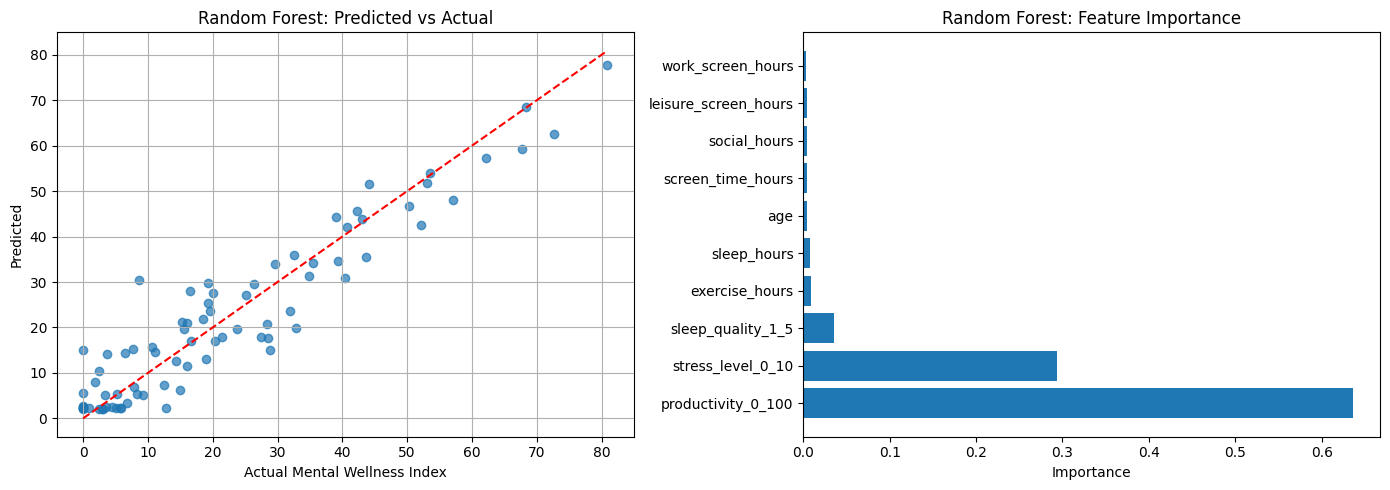


Top features:
                feature  importance
7    productivity_0_100    0.635724
6     stress_level_0_10    0.293196
5     sleep_quality_1_5    0.035160
8        exercise_hours    0.008322
4           sleep_hours    0.007541
0                   age    0.004641
1     screen_time_hours    0.004586
9          social_hours    0.004213
3  leisure_screen_hours    0.003929
2     work_screen_hours    0.002687


In [32]:
# Visualize Random Forest predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RF: Predicted vs Actual
axes[0].scatter(y_test_rf, y_pred_rf, alpha=0.7)
axes[0].plot([y_test_rf.min(), y_test_rf.max()], [y_test_rf.min(), y_test_rf.max()], 'r--')
axes[0].set_xlabel('Actual Mental Wellness Index')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Random Forest: Predicted vs Actual')
axes[0].grid(True)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf_model.named_steps['model'].feature_importances_
}).sort_values('importance', ascending=False)

axes[1].barh(feature_importance['feature'], feature_importance['importance'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Random Forest: Feature Importance')

plt.tight_layout()
plt.show()

print("\nTop features:")
print(feature_importance.head(10))


In [ ]:
# Check available columns for screentime and sleep
print("Available columns:")
print(df.columns.tolist())
print("\nDataframe info:")
df.info()


In [ ]:
# === PREDICTING SLEEP QUALITY FROM SCREENTIME ===

# Select screentime features as predictors
screentime_cols = [col for col in df.columns if 'screen' in col.lower()]
print("Screentime columns found:", screentime_cols)

X_sleep = df[screentime_cols]
y_sleep = df['sleep_hours_per_night']  # Adjust column name if different

print(f"\nX_sleep shape: {X_sleep.shape}")
print(f"y_sleep shape: {y_sleep.shape}")
print(f"\nScreentime features:\n{X_sleep.head()}")
print(f"\nSleep quality target:\n{y_sleep.head()}")


In [ ]:
# Train SVR on screentime -> sleep quality
sleep_pipe_svr = Pipeline([
    ("scale", StandardScaler()),
    ("model", SVR())
])

sleep_mod_svr = GridSearchCV(
    estimator=sleep_pipe_svr,
    param_grid={"model__C": [0.1, 1, 10, 100], "model__kernel": ["linear", "rbf"]},
    cv=3
)

sleep_mod_svr.fit(X_sleep, y_sleep)
print("Best SVR parameters:", sleep_mod_svr.best_params_)
print("Best CV score:", sleep_mod_svr.best_score_)

# Evaluate on test set
X_train_sleep, X_test_sleep, y_train_sleep, y_test_sleep = train_test_split(
    X_sleep, y_sleep, test_size=0.2, random_state=42
)

best_svr_sleep = sleep_mod_svr.best_estimator_
y_pred_sleep_svr = best_svr_sleep.predict(X_test_sleep)

print(f"\nSVR Test RMSE: {root_mean_squared_error(y_test_sleep, y_pred_sleep_svr):.4f}")


In [ ]:
# Train Random Forest on screentime -> sleep quality
sleep_pipe_rf = Pipeline([
    ("scale", StandardScaler()),
    ("model", RandomForestRegressor(random_state=42))
])

sleep_mod_rf = GridSearchCV(
    estimator=sleep_pipe_rf,
    param_grid={
        "model__n_estimators": [50, 100],
        "model__max_depth": [5, 10, 15],
        "model__min_samples_split": [2, 5]
    },
    cv=3,
    n_jobs=-1
)

sleep_mod_rf.fit(X_sleep, y_sleep)
print("Best Random Forest parameters:", sleep_mod_rf.best_params_)
print("Best CV score:", sleep_mod_rf.best_score_)

best_rf_sleep = sleep_mod_rf.best_estimator_
y_pred_sleep_rf = best_rf_sleep.predict(X_test_sleep)

print(f"\nRandom Forest Test RMSE: {root_mean_squared_error(y_test_sleep, y_pred_sleep_rf):.4f}")

# Visualize both
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SVR
axes[0].scatter(y_test_sleep, y_pred_sleep_svr, alpha=0.7)
axes[0].plot([y_test_sleep.min(), y_test_sleep.max()], 
             [y_test_sleep.min(), y_test_sleep.max()], 'r--')
axes[0].set_xlabel('Actual Sleep Hours')
axes[0].set_ylabel('Predicted')
axes[0].set_title('SVR: Screentime → Sleep Quality')
axes[0].grid(True)

# Random Forest
axes[1].scatter(y_test_sleep, y_pred_sleep_rf, alpha=0.7)
axes[1].plot([y_test_sleep.min(), y_test_sleep.max()], 
             [y_test_sleep.min(), y_test_sleep.max()], 'r--')
axes[1].set_xlabel('Actual Sleep Hours')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Random Forest: Screentime → Sleep Quality')
axes[1].grid(True)

plt.tight_layout()
plt.show()
